# Milestone Poject 2 : skimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here : https://arxiv.org/abs/1710.06071
        
And reading through the paper above, we see that the model architecture that they use to achieve their best results is available : https://arxiv.org/abs/1612.05251
        
*Resource :* If you want to find the ground truth for this notebook(with lots of diagrams and text annotation) see the Github: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb



## Import dependencies

In [46]:
# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
# Import dependencies
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# sys.path.append(r"C:\Users/wjub/01workspace/TensorFlow Developer Certificate ZTM")
sys.path.append(r"/content/drive/MyDrive/TensorFlow_Developer_Certificate_ZTM/")

import helper_functions
from helper_functions import calculate_results
import random

In [11]:
# Confirm acces to GPU
!nvidia-smi

Mon Feb 27 21:14:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    48W / 400W |   1169MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data and process data

Since we'll be replicating the paper above (PubMed 200K RCT)? let's download the dataset they used,
We can do so from the authors GitHub : 

In [12]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
# Check what files are in the PubMed_20K dataset


fatal: destination path 'pubmed-rct' already exists and is not an empty directory.


In [13]:
ls pubmed-rct

PubMed_200k_RCT/
PubMed_200k_RCT_numbers_replaced_with_at_sign/
PubMed_20k_RCT/
PubMed_20k_RCT_numbers_replaced_with_at_sign/
README.md


In [14]:
ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [15]:
# Start our experiments using the 20k dataset with numbers replaced by "#" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [16]:
# Check all of the filenames in the target directory
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

### Preprocess data 

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with data is to...

> Visualize, visualize, vizualize

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [17]:
# Create function to read lines of a document
def get_lines(filename):
    """
    Reads filename (a text filename) and returns the line of text as list.
    
    Args:
    	filename: a string containing the target filepath.
    Returns:
    	A list of strings with one string with one string per line from the target filename.  
    """
    with open(filename, "r") as f:
        return f.readlines()

In [18]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:30]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [19]:
len(train_lines)

210040

In [20]:
from helper_functions import preprocess_text_with_line_numbers

In [21]:
# Get data from file and preprocess it 
%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs
180040 30212 30135


Now that our data is the frormat of a list of ditionaries, how about we turn it into dataframe to futher visualize it?

In [22]:
# check the first abstract_line
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(train_samples)
#train_df["target"] = numeric_labels
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


In [23]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<AxesSubplot:ylabel='Frequency'>

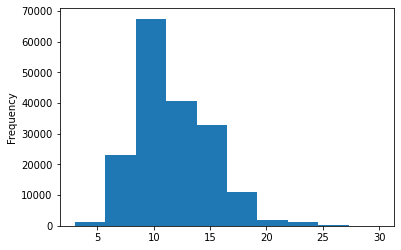

In [24]:
# let's check length of different lines
train_df.total_lines.plot.hist()

### Get lists of senteces

In [25]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)


(180040, 180040, 180040)

In [19]:
# View the 10 lines o ftraining sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML models require numeric labels)

In [20]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [21]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

###  Label encode labels

In [22]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"])
val_labels_encoded = label_encoder.fit_transform(val_df["target"])
test_labels_encoded = label_encoder.fit_transform(test_df["target"])

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [23]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models ans seeing which one works best.

And as always, we're going to start with a baseline (TF-IDF Multinomial Naive Bayes classifier).

## Model_0 : Getting a baseline

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline ([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
# fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [25]:
# Evaluate the model
baseline_score = model_0.score(val_sentences,val_labels_encoded)
print(f"our baseline model achive an accuracy of : {baseline_score}")

our baseline model achive an accuracy of : 0.7516829593423684


In [26]:
# make prediction
baseline_pred_probs = model_0.predict(val_sentences)
baseline_preds = tf.squeeze(tf.round(baseline_pred_probs))
baseline_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 2, 4, 2, 2, 4, 4, 4, 4, 4])>

In [27]:
model_0_results = helper_functions.calculate_results(val_labels_encoded, baseline_preds)
model_0_results

{'accuracy': 75.16829593423684,
 'precision': 0.7556121877731266,
 'recall': 0.7516829593423684,
 'f1': 0.734085177322999}

## Prepare our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers

In [28]:
# how long is each sentence on average ? 
sent_lens = [len(sentence.split()) for sentence in train_sentences] # list of length of words
avg_sent_len = np.mean(sent_lens)
avg_sent_len
#avg_sent_len, nb_word_per_sentence/len(train_sentences)

26.338269273494777

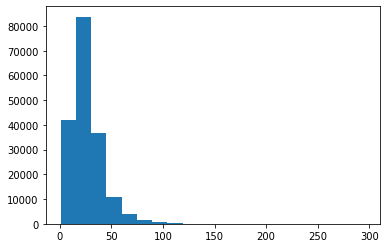

In [29]:
plt.hist(sent_lens, bins=20);

In [30]:
# How long  of sentence lenght covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len 

55

In [31]:
# Maximum sequence length in the training set
max(sent_lens)

296

## Embedding and tokenization
We want to make a layer which maps our texts from words to numbers

In [32]:
# How many words are in our vocab? (taken from table 2 in : https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [33]:
# lets create a text vectorizer use text vectorisation layers of the last video
from helper_functions import tokenization, embedding
# init the tokenizer function
init_tokenizer = tokenization(train_sentences, output_seq_len, max_vocab_length=68000) 

# Choose a random sentence from the training dataset and tokenize it 
random_sentence = random.choice(train_sentences)
text_vectorizer = init_tokenizer([random_sentence])


In [34]:
# How many words in our training vocabulary
rct_20k_text_vocab = init_tokenizer.get_vocabulary()
print(f"Number of words i vocab:{len(rct_20k_text_vocab)}\n")
print(f"Most common words in the vocab:{rct_20k_text_vocab[:5]}\n")
print(f"least common words in the vocab:{rct_20k_text_vocab[-5:]}\n")

Number of words i vocab:64841

Most common words in the vocab:['', '[UNK]', 'the', 'and', 'of']

least common words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']



In [35]:
init_tokenizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

### Create custom text embedding

### Embedding with Glove : make_it_like_function

In [36]:
# embedding Glove 
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-02-27 21:05:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-27 21:05:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-27 21:05:18--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

gl

In [37]:

word_index = dict(zip(rct_20k_text_vocab, range(len(rct_20k_text_vocab))))

path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

num_tokens = len(rct_20k_text_vocab) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

from tensorflow.keras.layers import Embedding

init_embedding = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

# Init embedding with glove embedding layer 
text_embedding = init_embedding(text_vectorizer)
text_embedding 


Found 400000 word vectors.
Converted 29730 words (35111 misses)


<tf.Tensor: shape=(1, 55, 100), dtype=float32, numpy=
array([[[ 0.39342 ,  1.016   ,  0.47467 , ..., -0.69452 ,  0.064015,
          0.016477],
        [ 0.44355 ,  0.3374  ,  0.68956 , ..., -0.9571  ,  0.45286 ,
          0.16091 ],
        [-0.1529  , -0.24279 ,  0.89837 , ..., -0.591   ,  1.0039  ,
          0.20664 ],
        ...,
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]]], dtype=float32)>

In [38]:
# Init embedding 
init_embedding = embedding( output_seq_len,len(rct_20k_text_vocab), output_seq_len)
text_embedding = init_embedding(text_vectorizer)
text_embedding

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.03583677,  0.00689657,  0.02079371, ..., -0.00930589,
          0.01535893, -0.04228828],
        [ 0.02387359,  0.04312244, -0.02352003, ...,  0.04942748,
         -0.02873398, -0.04079298],
        [ 0.04808071,  0.03014959, -0.0234941 , ...,  0.02147343,
         -0.00488131,  0.04759185],
        ...,
        [-0.00386272,  0.01014292,  0.0080789 , ..., -0.0267296 ,
         -0.01510002,  0.0357677 ],
        [-0.00386272,  0.01014292,  0.0080789 , ..., -0.0267296 ,
         -0.01510002,  0.0357677 ],
        [-0.00386272,  0.01014292,  0.0080789 , ..., -0.0267296 ,
         -0.01510002,  0.0357677 ]]], dtype=float32)>

In [39]:
# Show example embedding
print(f"Sentence before vectorization:\n {random_sentence}\n")
print(f"sentence after vectorization: \n {text_vectorizer}")
print(f"sentence after embedding: \n {text_embedding}")
print(f"embedding sentence shape:\n {text_embedding.shape}")

Sentence before vectorization:
 grade @-@ aes of special interest with bevacizumab occurred in @ % of bevacizumab-treated patients and @ % of placebo-treated patients , mainly grade @-@ hemorrhage ( bevacizumab @ % , placebo @ % ) .

sentence after vectorization: 
 [[  445   903     4  3347  1511     7  1034   344     5     4 19108    12
      3     4  3303    12  2080   445  1724  1034    48     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
sentence after embedding: 
 [[[-0.03583677  0.00689657  0.02079371 ... -0.00930589  0.01535893
   -0.04228828]
  [ 0.02387359  0.04312244 -0.02352003 ...  0.04942748 -0.02873398
   -0.04079298]
  [ 0.04808071  0.03014959 -0.0234941  ...  0.02147343 -0.00488131
    0.04759185]
  ...
  [-0.00386272  0.01014292  0.0080789  ... -0.0267296  -0.01510002
    0.0357677 ]
  [-0.00386272  0.01014292

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast a possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [40]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [41]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [42]:
# Take the TensorSliceDataset's and turn them into prefechted data
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [43]:
len(train_dataset)

5627

## Model 1 : Conv1D with token embeddings

In [44]:
# Create 1D conv model to process sequences
num_classes

5

In [45]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dense, Input
# create victorization, create embedding layer, create conv1D, pooling, dense layer
model_1 = tf.keras.Sequential([
    Input(shape=(1), dtype=tf.string, name='input_layer'),
    init_tokenizer,
    init_embedding,
    Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    GlobalAveragePooling1D(), # Condense the output of our feature vector from conv layer
    Dense(num_classes, activation='softmax')
], name='Conv1D')

# compile the model
model_1.compile(loss= "categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])
model_1.summary()

Model: "Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 8,340,997
Trainable params: 8,340,997
Non-trai

In [ ]:
# fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)), 
                              epochs=3,
                              validation_data= valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                                    experiment_name="model_1_conv1D")])

Saving TensorBoard log files to: tensorboard/model_1_conv1D/20230227-211230
Epoch 1/3
 66/562 [==>...........................] - ETA: 1:04 - loss: 1.4543 - accuracy: 0.3958

In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

In [ ]:
# Make predictions (our model predicts prediction probabilies for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape # output = proba of ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']

In [ ]:
# Convert pred_probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_1_preds)
model_1_results

## Model_2 : TensorFlow Hub Pretrained Feature Extractor

Now lets use pretrained word embedding from TensorFlow Hub, more specifically the universal sentence encoder(universal-sentence-encoder): https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVee embeddings, however, we're going to stick with the later created USE pretrained embedding

### Methode 2 use bert embedding 

In [1]:
#!pip3 install --quiet tensorflow-text

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

# Define some sentences to feed into the model
sentences = [
  "Here We Go Then, You And I is a 1999 album by Norwegian pop artist Morten Abel. It was Abel's second CD as a solo artist.",
  "The album went straight to number one on the Norwegian album chart, and sold to double platinum.",
  "Ceylon spinach is a common name for several plants and may refer to: Basella alba Talinum fruticosum",
  "A solar eclipse occurs when the Moon passes between Earth and the Sun, thereby totally or partly obscuring the image of the Sun for a viewer on Earth.",
  "A partial solar eclipse occurs in the polar regions of the Earth when the center of the Moon's shadow misses the Earth.",
]

# Load the BERT encoder and preprocessing models
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert = hub.load('https://tfhub.dev/google/experts/bert/pubmed/2')



In [26]:
# Convert the sentences to bert inputs
bert_inputs = preprocess(train_sentences[:5])

# Feed the inputs to the model to get the pooled and sequence outputs
bert_outputs = bert(bert_inputs, training=False)
pooled_output = bert_outputs['pooled_output']
sequence_output = bert_outputs['sequence_output']

print('\nSentences:')
print(sentences)
print('\nPooled output:')
print(pooled_output)
print('\nSequence output:')
print(sequence_output)


Sentences:
["Here We Go Then, You And I is a 1999 album by Norwegian pop artist Morten Abel. It was Abel's second CD as a solo artist.", 'The album went straight to number one on the Norwegian album chart, and sold to double platinum.', 'Ceylon spinach is a common name for several plants and may refer to: Basella alba Talinum fruticosum', 'A solar eclipse occurs when the Moon passes between Earth and the Sun, thereby totally or partly obscuring the image of the Sun for a viewer on Earth.', "A partial solar eclipse occurs in the polar regions of the Earth when the center of the Moon's shadow misses the Earth."]

Pooled output:
tf.Tensor(
[[-0.6477918  -0.70684963  0.1331164  ... -0.46288487  0.04282047
  -0.63427424]
 [-0.01562373 -0.5545997  -0.14161977 ... -0.2615973  -0.30270973
  -0.8866951 ]
 [ 0.13275665 -0.40689522 -0.827661   ... -0.43283406 -0.44427055
  -0.8223595 ]
 [ 0.02280793 -0.45343328 -0.18827845 ... -0.39480573 -0.52732015
  -0.6146176 ]
 [-0.11924198 -0.60044813 -0.8

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                  trainable=False,
                                  name="universal_sentence_encoder")
embeddings = tf_hub_embedding_layer([
    "The quick brown fox jumps over the lazy dog.",
    "I am a sentence for which I would like to get its embedding"])

print(embeddings)

tf.Tensor(
[[-0.03133018 -0.06338634 -0.01607501 ... -0.0324278  -0.04575739
   0.05370454]
 [ 0.05080859 -0.01652432  0.01573777 ...  0.00976659  0.03170121
   0.01788116]], shape=(2, 512), dtype=float32)


In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"sentence after embedding:\n{use_embedded_sentence[0][:30]}")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 primary endpoint was the incidence of therapeutical ( clinical and/or virologic ) failure at week @ with follow-up till week @ .
sentence after embedding:
[-0.01631023 -0.04433727 -0.07154287 -0.08110175 -0.04602405  0.00353554
  0.06861764 -0.05391749  0.04383511  0.02889834  0.06854235  0.07598585
 -0.04027563 -0.0678735   0.04709596  0.00211256 -0.09713444  0.01677616
  0.04302616  0.01995236 -0.02140223  0.04835825 -0.06138327  0.04035938
 -0.04575083 -0.06862703 -0.08881287 -0.07290141 -0.03595865  0.0140894 ]
Length of sentence embedding: 512


### Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub 

In [ ]:
model_2 = tf.keras.Sequential([
    tf_hub_embedding_layer,
    tf.keras.layers.Dense(5, activation='sigmoid')
])
# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# fit the model
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset)),
            callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                    experiment_name="model_2_tf_hub_embed")])

In [ ]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype="string"),
    tf_hub_embedding_layer, # tokenize text and create embedding of each sequence (512 long vector)
    tf.keras.layers.Dense(128, activation="relu"),
    # Note : you could add more layers here if you wanted to
    tf.keras.layers.Dense(num_classes, activation='sigmoid', name="output_layer")
], name="model_2_tf_hub_embed")

# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# fit the model
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                    experiment_name="model_2_tf_hub_embed")])

In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

In [ ]:

# Make some prediction wit feature extraction model
model_2_pred_probs = model_2.predict(val_sentences)

In [ ]:
# convert the prediction probabilities found with feature extraction model to label
model_2_pred = tf.argmax(model_2_pred_probs, axis=1) # les positions des  valeur les plus grandes 
model_2_pred

In [ ]:
# Calcute results performance from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true =val_labels_encoded,
                                    y_pred = model_2_pred)
model_2_results

In [ ]:
model_0_results

In [ ]:
model_1_results

## Model 3: Conv1D with character embeddngs

The paper which we're replicating states they used a combination of token and character-level embeddings.
:
Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Create a characterlevel tokenizer

In [ ]:
# tr = train_sentences.split("")
#init_tokenizer
type(train_sentences)

list

In [ ]:
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'p r i m a r y   e n d p o i n t   w a s   t h e   i n c i d e n c e   o f   t h e r a p e u t i c a l   (   c l i n i c a l   a n d / o r   v i r o l o g i c   )   f a i l u r e   a t   w e e k   @   w i t h   f o l l o w - u p   t i l l   w e e k   @   .'

In [ ]:
# Split sequence-level data splits into character-level data splits 
train_chars = [split_chars(sentence) for sentence in train_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# What's the average character length ?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

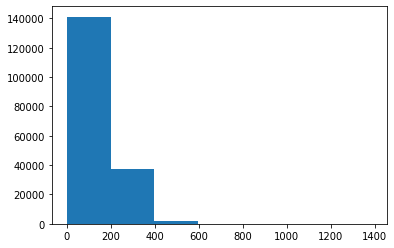

In [ ]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')


    # Create a text vectorizer 
char_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                                                               output_sequence_length= output_seq_char_len,
                                                                               #standardize=None, # set standardization to "None" if you want leave the ponctuation in
                                                                               name="char_vectorizer")


In [ ]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
 # Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: {len(random_train_chars)}")

vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 c h i l d r e n   w e r e   a b l e   t o   l e a r n   t h e   f o s   t h r o u g h   m p   o r   p p   w i t h   a   s i m i l a r   l e v e l   o f   p e r f o r m a n c e   .
Length of random_train_chars: 179
\Vectorized chars:
 [[11 13  4 12 10  8  2  6 20  2  8  2  5 22 12  2  3  7 12  2  5  8  6  3
  13  2 17  7  9  3 13  8  7 16 18 13 15 14  7  8 14 14 20  4  3 13  5  9
   4 15  4 12  5  8 12  2 21  2 12  7 17 14  2  8 17  7  8 15  5  6 11  2
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  

### Creating a character level embedding

In [ ]:
# Create char embedding layer
char_embed = tf.keras.layers.Embedding(input_dim=len(char_vocab), # this is the number of differente characters
                                       output_dim= 25, # is the size of char_embedding in  the paper (figure 1)
                                       mask_zero=True,
                                       name="char_embed")

In [ ]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f" Embedded chars. (after vectorization and embedding) :\n {char_embed_example}")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 c h i l d r e n   w e r e   a b l e   t o   l e a r n   t h e   f o s   t h r o u g h   m p   o r   p p   w i t h   a   s i m i l a r   l e v e l   o f   p e r f o r m a n c e   .
 Embedded chars. (after vectorization and embedding) :
 [[[ 0.00103297  0.02409265  0.04127543 ...  0.04038123  0.0362894
    0.00532508]
  [-0.03035563  0.01923693  0.00054065 ... -0.01868808 -0.01045972
   -0.01360084]
  [ 0.04035938  0.00890691  0.03018607 ...  0.00264982 -0.01284679
   -0.00804849]
  ...
  [ 0.03026551  0.03709862  0.03611063 ...  0.03640194  0.04618958
    0.04187285]
  [ 0.03026551  0.03709862  0.03611063 ...  0.03640194  0.04618958
    0.04187285]
  [ 0.03026551  0.03709862  0.03611063 ...  0.03640194  0.04618958
    0.04187285]]]
Character embedding shape: (1, 290, 25)


In [ ]:
len(random_train_chars)

179

In [ ]:
# Check the image in notion and build a model like this

### Building a Conv1D model to fit on character embeddings

In [ ]:
# Create the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="input_layer"),
    char_vectorizer,
    char_embed,
    tf.keras.layers.Conv1D(64,kernel_size=5, padding="same", activation="relu"),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(num_classes,activation="softmax",name="output_layer")
], name="Conv1D_char_embed")

# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_3.summary()

Model: "Conv1D_char_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 output_layer (Dense)        (None, 5)                 325       
                                                                 
Total params: 9,089
Trainable params: 9,089
Non-t

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model
history_model_3 = model_3.fit(train_char_dataset,
                             steps_per_epoch=int(0.1*len(train_char_dataset)),
                             epochs=3,
                             validation_data=val_char_dataset,
                             validation_steps=int(0.1*len(val_char_dataset)),
                             callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                                     experiment_name="model_3_conv1D_embed_char")])

In [ ]:
# Make prediction with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)

In [ ]:
# Convert preddiction probabilies to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

In [ ]:
model_3_results = calculate_results(y_true=train_labels_encoded, y_pred=model_3_preds)
model_3_results

## Model 4: Combining pretrained token embedding + characters embedding (hybrid embedding)

1. Create a token-level embedding model (similar `model_1`).
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 3 with a concatenate (`layers.Concatenate`).
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2(Training) of the paper https://arxiv.org/pdf/1612.05251.pdf.
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output.

In [ ]:
# 1. Setup token inputs/model
token_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_input"),
    tf_hub_embedding_layer,
    tf.keras.layers.Dense(128, activation="relu", name="output_layer")
], name="token_model")

# 2. Setup char inputs/model
char_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="char_input"),
    char_vectorizer,
    char_embed,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24), name="bi_lstm_output_layer")
], name="char_model")

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                    char_model.output])
# 4. Create output layers - adding in Dropout, discussed in section 4.2
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
output_layer = tf.keras.layers.Dense(num_classes, activation="sigmoid")(final_dropout)

# output_layer = tf.keras.Sequential([
#     tf.keras.layers.Dropout(0.5)(token_char_concat), # combined_dropout
#     tf.keras.layers.Dense(128, activation="relu"),   # combined_dense
#     tf.keras.layers.Dropout(0.5),                   # final_dropout
#     tf.keras.layers.Dense(num_classes, activation="sigmoid")
# ])

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

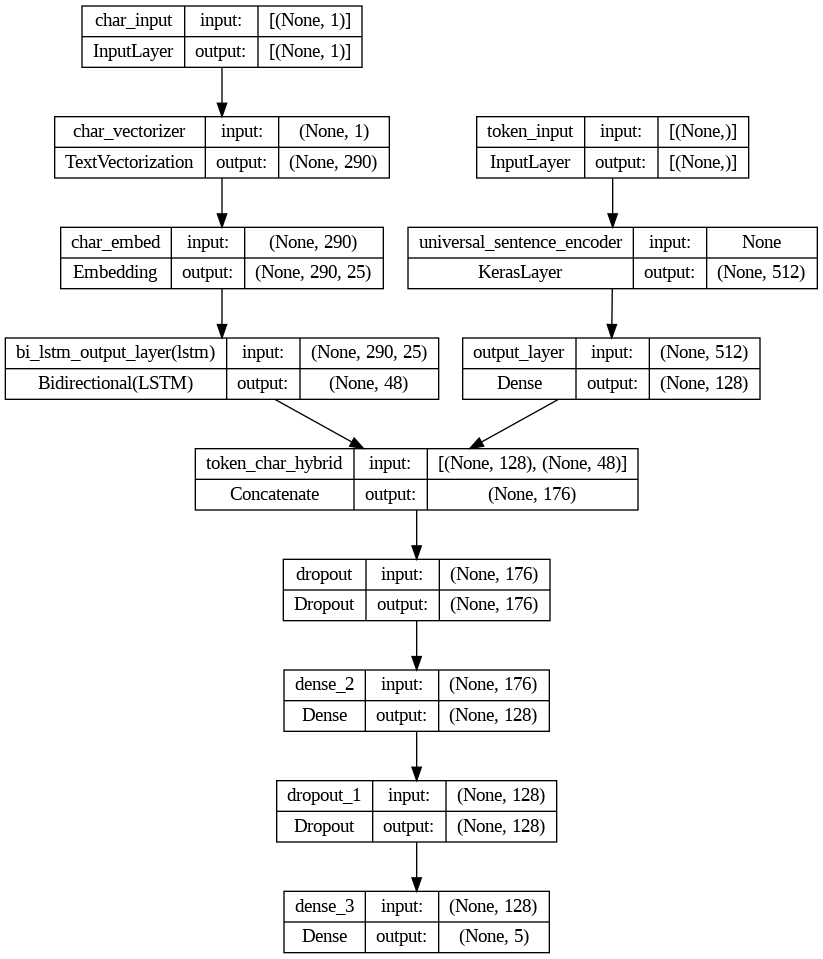

In [ ]:
# Plot hybrid token and charcter model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
 # Compile token char model
 model_4.compile(loss="categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(), # section 4.2 of the paper says use SGD
                 metrics=["accuracy"])

### Combining and characer data into a tf.data Dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data with labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data with labels

# Prefetch and batch train data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
 val_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)),
                              callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                                      experiment_name="model_4")])

In [ ]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
# Format pred probs into pred labels 
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds[:5]

In [ ]:
# get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded, y_pred=model_4_preds)
model_4_results

In [ ]:
# Get results of token-char-hybrid model


## Model 5 : Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


> **Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

 ### Create positional embeddings


In [ ]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<AxesSubplot:ylabel='Frequency'>

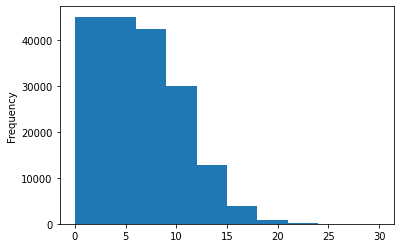

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)


train_line_numbers_one_hot[1], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(15,), dtype=float32, numpy=
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>, TensorShape([180040, 15]))

Now w've encoded our line numbers feature, let's do the same for our total lines feature...

In [ ]:
# How many different numbers of lines are there ?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

## Check the distributions of total lines

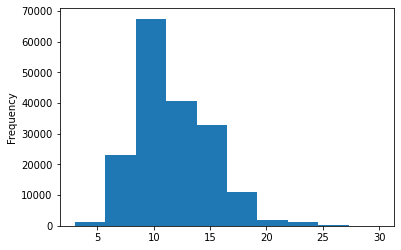

In [ ]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [ ]:
# Check the converage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
# Use tensorflow to create one hot encoded tensors of our "total_lines" features
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribried embedding and output label probabilities
8. Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model.

In [ ]:
# 1. Token inputs
token_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_inputs"),
    tf_hub_embedding_layer,
    tf.keras.layers.Dense(128, activation="relu"),
], name="token_model")

# 2. Char inputs
char_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1, ), dtype=tf.string, name="char_inputs"),
    char_vectorizer,
    char_embed,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24), name="bi_lstm_output")
], name="char_model")
    
# 3. Line numbers model
line_number_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name="input_line_numbers"),
    tf.keras.layers.Dense(32, activation="relu")    
],name="line_number_model")

# 4. Total lines model
total_line_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(20,), dtype=tf.float32, name="input_total_line_numbers"),
    tf.keras.layers.Dense(32, activation="relu")    
],name="total_line_model")

# 5. Combine token and cher embeddings into a hybrid embedding
combined_embeddings = tf.keras.layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                                       char_model.output])
z = tf.keras.layers.Dense(256, activation="relu")(combined_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings 
tribrid_embeddings = tf.keras.layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                       total_line_model.output,
                                                                                       combined_embeddings])
# 7. Create output layer
output_layer = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input], outputs =output_layer, name="tribrid_embedding_model")

In [ ]:
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

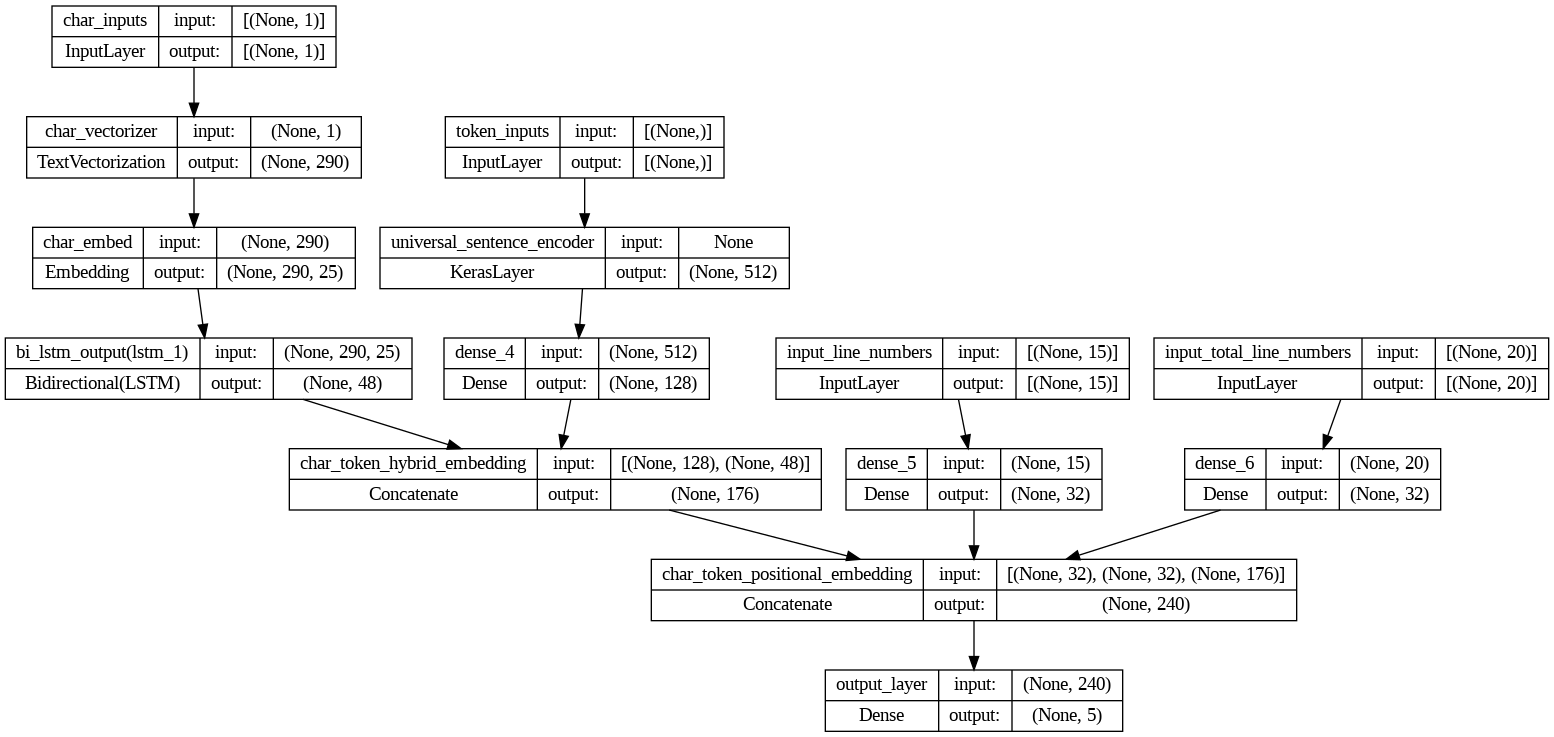

In [ ]:
# Plot hybrid token and charcter model
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing?

for example if our model gets too confident on a single class (e.g. its prediction probability is realyy high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

hat label smoothings does is it assings some of the value from the highest pred prob to other classes, it turn, hopefully improving generalization : `[0.01, 0.01, 0.96, 0.01, 0.01]`

> for more on label smoothing, see this blog post from PyImageSearch : https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [ ]:
# Compile token, char, and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # Helps to prevent overfiting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

## Create tribrid embedding using embedding dataset using tf.data


In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# DO THE SAME AS ABOVE BUT FOR THE VALIDATION DATASET
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making prediction with our tribrid model

In [ ]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs = 3,
                              validation_data = val_char_token_pos_dataset,
                              validation_steps = int(0.1*len(val_char_token_pos_dataset)),
                              callbacks=[helper_functions.create_tensorboard_callback(dir_name="tensorboard",
                                                                                      experiment_name="model_5_concat_4models")])

Saving TensorBoard log files to: tensorboard/model_5_concat_4models/20230226-143905
Epoch 1/3
562/562 [==============================] - 59s 76ms/step - loss: 1.1006 - accuracy: 0.7242 - val_loss: 0.9844 - val_accuracy: 0.8033
Epoch 2/3
562/562 [==============================] - 49s 86ms/step - loss: 0.9750 - accuracy: 0.8082 - val_loss: 0.9653 - val_accuracy: 0.8127
Epoch 3/3
562/562 [==============================] - 38s 67ms/step - loss: 0.9593 - accuracy: 0.8164 - val_loss: 0.9577 - val_accuracy: 0.8211


In [ ]:
model_5.summary()

In [ ]:
model_5.evaluate(val_char_token_pos_dataset)

In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:5]

5627/5627 [==============================] - 128s 22ms/step


<tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 2, 2, 2, 2])>

In [ ]:
model_5_results = helper_functions.calculate_results(y_true=val_labels_encoded, y_pred=model_5_preds)
model_5_results

{'accuracy': 82.13563652521661,
 'precision': 0.8203025589176887,
 'recall': 0.8213563652521662,
 'f1': 0.8204509831329341}

In [ ]:
model_4_results

## Compare model results

In [ ]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"model_0_baseline": model_0_results,
                                 "model_1_custom_token_embedding": model_1_results,
                                 "model_2_pretrained_token_embedding": model_2_results,
                                 "model_3_custom_char_embedding": model_3_results,
                                 "model_4_hybrid_char_token_embedding": model_4_results,
                                 "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

In [ ]:
# Sort model results by f1-score 
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

In [ ]:
# save the model

#model_0.save("save_models/model_0.H5")
#model_1.save("save_models/model_1.H5")
#model_2.save("save_models/model_2.H5")
#model_3.save("save_models/model_3.H5")
#model_4.save("save_models/model_4.H5")
model_5.save("drive/MyDrive/save_models/model_5_skimlit_project")


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
loaded_model_5 = tf.keras.models.load_model("drive/MyDrive/save_models/model_5.H5",
                                     custom_objects={"KerasLayer": hub.KerasLayer})

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
# How does our loaded model perform?
loaded_model_5.evaluate(val_char_token_pos_dataset)

5627/5627 [==============================] - 137s 24ms/step - loss: 0.9533 - accuracy: 0.8236


[0.953260064125061, 0.8236392140388489]

In [ ]:
# Make prediction with the loaded model on the validation set
model_5_pred_probs = loaded_model_5.predict(val_char_token_pos_dataset)
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds[:5]

5627/5627 [==============================] - 146s 26ms/step


<tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 2, 2, 2, 2])>

In [ ]:
# calculate the results of our loaded model
loaded_model_5_results = helper_functions.calculate_results(y_true=val_labels_encoded, y_pred=model_5_preds)
loaded_model_5_results

{'accuracy': 82.36391912908243,
 'precision': 0.822609805418878,
 'recall': 0.8236391912908243,
 'f1': 0.8228014714563803}

In [ ]:
assert model_5_results == loaded_model_5_results

True

In [ ]:
# Check the loaded model summary
loaded_model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

## Download and load in a pretained model from Google Storage

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

--2023-02-22 14:16:19--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 142.250.152.128, 142.250.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M  94.0MB/s    in 8.0s    

2023-02-22 14:16:27 (115 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

mkdir: cannot create directory ‘skimlit_gs_model’: File exists
Archive:  skimlit_tribrid_model.zip
replace skimlit_gs_model/skimlit_tribrid_model/variables/variables.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
replace skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001? [y]

In [ ]:
# load Google Storage modelyy
#loaded_gs_model = tf.keras.models.load_model('skimlit_gs_model/skimlit_tribrid_model/')

# Load the model with custom layer
#loaded_model = tf.keras.models.load_model('skimlit_gs_model/skimlit_tribrid_model/')
#

In [ ]:
!ls skimlit_tribrid_model

ls: cannot access 'skimlit_tribrid_model': No such file or directory


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model
loaded_model = tf.saved_model.load('skimlit_gs_model/skimlit_tribrid_model/')

--2023-02-22 16:52:30--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962561955 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.97M  40.3MB/s    in 24s     

2023-02-22 16:52:54 (38.8 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962561955/962561955]

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras

In [ ]:
loaded_model = tf.keras.models.load_model('skimlit_gs_model/skimlit_tribrid_model/')

# Skimlit_exercices

## 1. Train model_5 on all of the data in the training dataset for as many epochs until it stops improving. Since this might take a while, you might want to use:
- tf.keras.callbacks.ModelCheckpoint to save the model's best weights only.
- tf.keras.callbacks.EarlyStopping to stop the model from training once the validation loss has stopped improving for ~3 epochs.

In [2]:
# Import dependencies
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# sys.path.append(r"C:\Users/wjub/01workspace/TensorFlow Developer Certificate ZTM")
sys.path.append(r"/content/drive/MyDrive/TensorFlow_Developer_Certificate_ZTM/")

import helper_functions
from helper_functions import calculate_results
import random
from helper_functions import preprocess_text_with_line_numbers

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
# Check what files are in the PubMed_20K dataset

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 8.89 MiB/s, done.


In [4]:
# dir of our experiments using the 200k dataset with numbers replaced by "#" sign
data_dir = "pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [6]:
!unzip pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip -d pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

Archive:  pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt  


In [7]:
# Check all of the filenames in the target directory
import os
filenames= [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [8]:
# Get data from file and preprocess it 
%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs
2211861 28932 29493


In [9]:
# check the first abstract_line
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(train_samples)
#train_df["target"] = numeric_labels
train_df

,target,text,line_number,total_lines
0,BACKGROUND,the emergence of hiv as a chronic condition me...,0,10
1,BACKGROUND,this paper describes the design and evaluation...,1,10
2,METHODS,this study is designed as a randomised control...,2,10
3,METHODS,the intervention group will participate in the...,3,10
4,METHODS,the program is based on self-efficacy theory a...,4,10
...,...,...,...,...
2211856,METHODS,"after crossover , the wait-list group received...",5,9
2211857,METHODS,performance was assessed by comparison to amer...,6,9
2211858,RESULTS,performance improved significantly after simul...,7,9
2211859,RESULTS,no improvement was detected as a function of c...,8,9


In [10]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)



(2211861, 2211861, 2211861)

In [11]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [12]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[1], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(15,), dtype=float32, numpy=
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)>, TensorShape([2211861, 15]))

In [13]:
# Use tensorflow to create one hot encoded tensors of our "total_lines" features
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([2211861, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

In [14]:
def split_chars(text):
  return " ".join(list(text))
  
# Split sequence-level data splits into character-level data splits 
train_chars = [split_chars(sentence) for sentence in train_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
train_chars[0]

't h e   e m e r g e n c e   o f   h i v   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   h i v   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .'

In [15]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# DO THE SAME AS ABOVE BUT FOR THE VALIDATION DATASET
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [16]:
# Define the callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_weights',
                                                         monitor='val_loss',
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         verbose=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=3,
                                                           verbose=1)


In [17]:
# # Download pretrained TensorFlow Hub USE
# import tensorflow_hub as hub

# tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
#                                   trainable=False,
#                                   name="universal_sentence_encoder")
# embeddings = tf_hub_embedding_layer([
#     "The quick brown fox jumps over the lazy dog.",
#     "I am a sentence for which I would like to get its embedding"])

# print(embeddings)

In [18]:
# # Find what character length covers 95% of sequences
# output_seq_char_len = int(np.percentile(char_lens, 95))
# output_seq_char_len

In [19]:
# # Test out the pretrained embedding on a random sentence
# random_train_sentence = random.choice(train_sentences)
# print(f"Random sentence:\n {random_train_sentence}")
# use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
# print(f"sentence after embedding:\n{use_embedded_sentence[0][:30]}")
# print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

# def split_chars(text):
#   return " ".join(list(text))

# # Text splitting non-character-level sequence into characters
# split_chars(random_train_sentence)


In [20]:

# # Split sequence-level data splits into character-level data splits 
# train_chars = [split_chars(sentence) for sentence in train_sentences]
# test_chars = [split_chars(sentence) for sentence in test_sentences]
# val_chars = [split_chars(sentence) for sentence in val_sentences]
# train_chars[0]

In [21]:


# # What's the average character length ?
# char_lens = [len(sentence) for sentence in train_sentences]
# mean_char_len = np.mean(char_lens)
# mean_char_len

# # Get all keyboard characters
# import string
# alphabet = string.ascii_lowercase + string.digits + string.punctuation
# alphabet

# # Create char-level token vectorizer instance
# NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')

# # Find what character length covers 95% of sequences
# output_seq_char_len = int(np.percentile(char_lens, 95))
# output_seq_char_len

#     # Create a text vectorizer 
# char_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens = NUM_CHAR_TOKENS,
#                                                                                output_sequence_length= output_seq_char_len,
#                                                                                #standardize=None, # set standardization to "None" if you want leave the ponctuation in
#                                                                                name="char_vectorizer")


In [22]:
# # Adapt character vectorizer to training character
# char_vectorizer.adapt(train_chars)

#  # Check character vocab stats
# char_vocab = char_vectorizer.get_vocabulary()
# print(f"Number of different characters in character vocab: {len(char_vocab)}")
# print(f"5 most common characters: {char_vocab[:5]}")
# print(f"5 least common characters: {char_vocab[-5:]}")

# # Create char embedding layer
# char_embed = tf.keras.layers.Embedding(input_dim=len(char_vocab), # this is the number of differente characters
#                                        output_dim= 25, # is the size of char_embedding in  the paper (figure 1)
#                                        mask_zero=True,
#                                        name="char_embed")

In [23]:
# # 1. Token inputs
# token_model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=[], dtype=tf.string, name="token_inputs"),
#     tf_hub_embedding_layer,
#     tf.keras.layers.Dense(128, activation="relu"),
# ], name="token_model")

# # 2. Char inputs
# char_model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(1, ), dtype=tf.string, name="char_inputs"),
#     char_vectorizer,
#     char_embed,
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24), name="bi_lstm_output")
# ], name="char_model")
    
# # 3. Line numbers model
# line_number_model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name="input_line_numbers"),
#     tf.keras.layers.Dense(32, activation="relu")    
# ],name="line_number_model")

# # 4. Total lines model
# total_line_model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(20,), dtype=tf.float32, name="input_total_line_numbers"),
#     tf.keras.layers.Dense(32, activation="relu")    
# ],name="total_line_model")

# # 5. Combine token and cher embeddings into a hybrid embedding
# combined_embeddings = tf.keras.layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
#                                                                                        char_model.output])
# z = tf.keras.layers.Dense(256, activation="relu")(combined_embeddings)
# z = tf.keras.layers.Dropout(0.5)(z)

# # 6. Combine positional embedding with combined token and char embeddings 
# tribrid_embeddings = tf.keras.layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
#                                                                                        total_line_model.output,
#                                                                                        combined_embeddings])
# # 7. Create output layer
# output_layer = tf.keras.layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# # 8. Put together model with all kinds of inputs
# model_5 = tf.keras.Model(inputs=[line_number_model.input,
#                                  total_line_model.input,
#                                  token_model.input,
#                                  char_model.input], outputs =output_layer, name="tribrid_embedding_model")

In [24]:
# # Compile token, char, and positional embedding model
# model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # Helps to prevent overfiting
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])

In [25]:
# import tensorflow_hub as hub
import tensorflow as tf
loaded_model_5 = tf.keras.models.load_model("drive/MyDrive/save_models/model_5.H5")

In [26]:
loaded_model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

In [27]:
# Train the model with the callbacks
history_loaded_model_5 = loaded_model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.01*len(train_char_token_pos_dataset)),
                              validation_data=val_char_token_pos_dataset,
                              epochs=10,
                              validation_steps=int(0.01*len(val_char_token_pos_dataset)),
                              callbacks=[checkpoint_callback,
                                         early_stopping_callback])

Epoch 1/10
691/691 [==============================] - ETA: 0s - loss: 0.9338 - accuracy: 0.8362
Epoch 1: val_loss improved from inf to 0.91594, saving model to best_weights
691/691 [==============================] - 52s 48ms/step - loss: 0.9338 - accuracy: 0.8362 - val_loss: 0.9159 - val_accuracy: 0.8497
Epoch 2/10
689/691 [============================>.] - ETA: 0s - loss: 0.9357 - accuracy: 0.8329
Epoch 2: val_loss did not improve from 0.91594
691/691 [==============================] - 30s 43ms/step - loss: 0.9355 - accuracy: 0.8330 - val_loss: 0.9162 - val_accuracy: 0.8502
Epoch 3/10
690/691 [============================>.] - ETA: 0s - loss: 0.9306 - accuracy: 0.8384
Epoch 3: val_loss improved from 0.91594 to 0.91526, saving model to best_weights
691/691 [==============================] - 32s 46ms/step - loss: 0.9305 - accuracy: 0.8384 - val_loss: 0.9153 - val_accuracy: 0.8495
Epoch 4/10
690/691 [============================>.] - ETA: 0s - loss: 0.9219 - accuracy: 0.8435
Epoch 4: val

## 2. Checkout the Keras guide on using pretrained GloVe embeddings. Can you get this working with one of our models?
- Hint: You'll want to incorporate it with a custom token Embedding layer.
- It's up to you whether or not you fine-tune the GloVe embeddings or leave them frozen.

In [111]:
# SOLUTION : Check embedding with Glove above

## Try replacing the TensorFlow Hub Universal Sentence Encoder pretrained embedding for the TensorFlow Hub BERT PubMed expert (a language model pretrained on PubMed texts) pretrained embedding. Does this effect results?
- Note: Using the BERT PubMed expert pretrained embedding requires an extra preprocessing step for sequences (as detailed in the TensorFlow Hub guide).
- Does the BERT model beat the results mentioned in this paper? https://arxiv.org/pdf/1710.06071.pdf

## 4. What happens if you were to merge our line_number and total_lines features for each sequence? For example, created a X_of_Y feature instead? Does this effect model performance?
- Another example: line_number=1 and total_lines=11 turns into line_of_X=1_of_11.

## 5. Write a function (or series of functions) to take a sample abstract string, preprocess it (in the same way our model has been trained), make a prediction on each sequence in the abstract and return the abstract in the format:
- PREDICTED_LABEL: SEQUENCE
- PREDICTED_LABEL: SEQUENCE
- PREDICTED_LABEL: SEQUENCE
- PREDICTED_LABEL: SEQUENCE
- ...
  - You can find your own unstructured RCT abstract from PubMed or try this one from: Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection.
